## Multi-class classification

> Indented block



Iris dataset https://en.wikipedia.org/wiki/Iris_flower_data_set

In [55]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import numpy as np
import datetime, os
import math
import random
import torch
import matplotlib.pyplot as plt 
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
import itertools

## For this experiment we will use PyTorch framework

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [58]:
!wget http://klevas.mif.vu.lt/~linp/output/2_iris.csv

--2023-02-10 22:18:28--  http://klevas.mif.vu.lt/~linp/output/2_iris.csv
Resolving klevas.mif.vu.lt (klevas.mif.vu.lt)... 193.219.42.12
Connecting to klevas.mif.vu.lt (klevas.mif.vu.lt)|193.219.42.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2850 (2.8K) [text/csv]
Saving to: ‘2_iris.csv.1’

2_iris.csv.1        100%[===================>]   2.78K  --.-KB/s    in 0s      

2023-02-10 22:18:29 (261 MB/s) - ‘2_iris.csv.1’ saved [2850/2850]



#### Check if GPU is available

In [59]:
!nvidia-smi

Fri Feb 10 22:18:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [60]:
# Read the data
data = np.genfromtxt("./2_iris.csv", delimiter='\t') 

# Split data: train, validation, testing
N_samples = data.shape[0]
N_train = int(N_samples * 0.7) # 70% Train
N_val = int(N_samples * 0.8) # 10% Validation
N_test = N_samples - N_train - N_val

In [61]:
N_samples

150

In [62]:
data

array([[5.1, 3.5, 1.4, 0.2, 0. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [4.7, 3.2, 1.3, 0.2, 0. ],
       [4.6, 3.1, 1.5, 0.2, 0. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [5.4, 3.9, 1.7, 0.4, 0. ],
       [4.6, 3.4, 1.4, 0.3, 0. ],
       [5. , 3.4, 1.5, 0.2, 0. ],
       [4.4, 2.9, 1.4, 0.2, 0. ],
       [4.9, 3.1, 1.5, 0.1, 0. ],
       [5.4, 3.7, 1.5, 0.2, 0. ],
       [4.8, 3.4, 1.6, 0.2, 0. ],
       [4.8, 3. , 1.4, 0.1, 0. ],
       [4.3, 3. , 1.1, 0.1, 0. ],
       [5.8, 4. , 1.2, 0.2, 0. ],
       [5.7, 4.4, 1.5, 0.4, 0. ],
       [5.4, 3.9, 1.3, 0.4, 0. ],
       [5.1, 3.5, 1.4, 0.3, 0. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.1, 3.8, 1.5, 0.3, 0. ],
       [5.4, 3.4, 1.7, 0.2, 0. ],
       [5.1, 3.7, 1.5, 0.4, 0. ],
       [4.6, 3.6, 1. , 0.2, 0. ],
       [5.1, 3.3, 1.7, 0.5, 0. ],
       [4.8, 3.4, 1.9, 0.2, 0. ],
       [5. , 3. , 1.6, 0.2, 0. ],
       [5. , 3.4, 1.6, 0.4, 0. ],
       [5.2, 3.5, 1.5, 0.2, 0. ],
       [5.2, 3.4, 1.4, 0.2, 0. ],
       [4.7, 3

In [63]:

# randomizuojame stebėjimus
shuffle_data = [x for x in np.random.permutation(N_samples)]
data = data[shuffle_data,:]


In [64]:
data

array([[6.7, 3.1, 4.7, 1.5, 1. ],
       [6.6, 3. , 4.4, 1.4, 1. ],
       [5.5, 2.5, 4. , 1.3, 1. ],
       [7.2, 3.6, 6.1, 2.5, 2. ],
       [6.1, 2.9, 4.7, 1.4, 1. ],
       [6.4, 3.2, 4.5, 1.5, 1. ],
       [6.9, 3.2, 5.7, 2.3, 2. ],
       [6. , 2.7, 5.1, 1.6, 1. ],
       [5.6, 2.7, 4.2, 1.3, 1. ],
       [7.3, 2.9, 6.3, 1.8, 2. ],
       [6.7, 2.5, 5.8, 1.8, 2. ],
       [5.8, 2.8, 5.1, 2.4, 2. ],
       [6.1, 2.8, 4. , 1.3, 1. ],
       [5.3, 3.7, 1.5, 0.2, 0. ],
       [5.5, 2.4, 3.7, 1. , 1. ],
       [5.5, 2.6, 4.4, 1.2, 1. ],
       [6.8, 2.8, 4.8, 1.4, 1. ],
       [6.5, 3. , 5.5, 1.8, 2. ],
       [6.7, 3.3, 5.7, 2.5, 2. ],
       [5. , 3.6, 1.4, 0.2, 0. ],
       [6.3, 2.3, 4.4, 1.3, 1. ],
       [7.2, 3. , 5.8, 1.6, 2. ],
       [6.2, 2.9, 4.3, 1.3, 1. ],
       [5.7, 2.6, 3.5, 1. , 1. ],
       [5.7, 3.8, 1.7, 0.3, 0. ],
       [5.9, 3. , 5.1, 1.8, 2. ],
       [4.9, 3. , 1.4, 0.2, 0. ],
       [6. , 3. , 4.8, 1.8, 2. ],
       [6.1, 2.8, 4.7, 1.2, 1. ],
       [5.1, 2

In [65]:
## creating one-hot encoding dummy variables 
def batch_to_one_hot(id, batch_size, nb_classes = 10):
    y_onehot = torch.FloatTensor(batch_size, nb_classes)
    y_onehot.zero_()
    y_onehot.scatter_(1, id.view(-1, 1), 1)
    return y_onehot.long()

In [66]:

# Set data -> test, validation, test
data_train = torch.tensor(data[:N_train,:4]).float()
y_train = torch.tensor(data[:N_train,4], dtype= torch.int64)
y_train = batch_to_one_hot(y_train, y_train.shape[0], 3)
data_train.shape

data_val = torch.tensor(data[N_train:N_val,:4]).float()
y_val = torch.tensor(data[N_train:N_val,4], dtype= torch.int64)
y_val = batch_to_one_hot(y_val, y_val.shape[0], 3)
data_val.shape

data_test = torch.tensor(data[N_val:,:4]).float()
y_test = torch.tensor(data[N_val:,4], dtype= torch.int64)
y_test = batch_to_one_hot(y_test, y_test.shape[0], 3)
data_test.shape

torch.Size([30, 4])

In [67]:
y_train

tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 

In [68]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 15)
        self.bn2 = nn.BatchNorm1d(15)
        self.fc3 = nn.Linear(15, 3)
        self.softmax = nn.Softmax()
        self.drop = nn.Dropout(p=0.4)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.drop(X)
        X = self.bn1(X)
        X = self.fc2(X)
        X = self.drop(X)
        X = self.bn2(X)
        X = self.fc3(X)
        X = F.softmax(X)

        return X

model = NeuralNet()

In [69]:
# Selecting some loss function
loss_func =  nn.CrossEntropyLoss() 

In [70]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss_func(input, target)
input, target

(tensor([[-0.6938, -0.6621, -0.7019, -0.4165, -0.9063],
         [-0.1104,  1.1743, -1.5896,  1.8419, -1.8537],
         [-1.1408, -0.7207, -0.9161, -0.8855,  0.6774]], requires_grad=True),
 tensor([2, 1, 2]))

In [71]:

# selecting optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
# selecting number of epochs
n_epochs = 10

for epoch in range(0, n_epochs+1):

    if epoch == 0:
      torch.set_grad_enabled(False)

    # init some variables
    train_loss = 0.0
    validation_loss = 0.0
    train_acc = 0.0
    validation_acc = 0.0
    
    #########################################################
    # Training          
    #########################################################

    # reset gradients
    optimizer.zero_grad()
    # Calculating yhat from data x
    outputs = model(data_train)
    
    # calculate statistics
    with torch.no_grad():
      outputLabels = torch.argmax(outputs, 1)
      yLabels = torch.argmax(y_train, 1)
      accuracy = yLabels == outputLabels
      train_acc += torch.sum(accuracy.float())

    # calculating loss
    loss = loss_func(outputs, yLabels)

    # calculating gradients
    if epoch != 0:
      loss.backward()
    # update parameters
    optimizer.step()
    # calculating total loss
    train_loss += loss.item()*data_train.size(0)
        
        
    
    ##############################################################
    # Validation
    ##############################################################
    # Calculating prediction yhat
    outputs = model(data_val)
    # calculating val loss
    yLabels = torch.argmax(y_val, 1)
    loss = loss_func(outputs, yLabels)
    # total loss
    validation_loss += loss.item()*data_val.size(0)

    # calculating statistics
    with torch.no_grad():
      outputLabels = torch.argmax(outputs, 1)
      accuracy = yLabels == outputLabels
      validation_acc += torch.sum(accuracy.float())
            
    # statistics
    print('Epoch: {} \t Loss: {:.10f} \t Accuracy: {:.3f} \t Val loss: {:.10f} \t Val acc: {:.3f}'.format(
        epoch, 
        train_loss / N_train,
        train_acc / N_train,
        validation_loss / N_val,
        validation_acc / N_val,
        ))
    
    if epoch == 0:
      torch.set_grad_enabled(True)

test_loss = 0.0
################################################################
# Testing
################################################################

outputs = model(data_test)
yLabels = torch.argmax(y_test, 1)
loss = loss_func(outputs, yLabels)
test_loss += loss.item()*data_test.size(0)

print('Epoch: {} \t Test loss: {:.10f}'.format(
    epoch, 
    test_loss / N_test
    ))

Epoch: 0 	 Loss: 1.1213490963 	 Accuracy: 0.267 	 Val loss: 0.1445009261 	 Val acc: 0.025
Epoch: 1 	 Loss: 1.1027851105 	 Accuracy: 0.352 	 Val loss: 0.1376141012 	 Val acc: 0.042
Epoch: 2 	 Loss: 1.0948721170 	 Accuracy: 0.390 	 Val loss: 0.1363977790 	 Val acc: 0.050
Epoch: 3 	 Loss: 1.0756744146 	 Accuracy: 0.419 	 Val loss: 0.1359910965 	 Val acc: 0.042
Epoch: 4 	 Loss: 1.0590951443 	 Accuracy: 0.486 	 Val loss: 0.1361792833 	 Val acc: 0.050
Epoch: 5 	 Loss: 1.0602585077 	 Accuracy: 0.486 	 Val loss: 0.1300936639 	 Val acc: 0.067
Epoch: 6 	 Loss: 1.0419073105 	 Accuracy: 0.533 	 Val loss: 0.1334212422 	 Val acc: 0.058
Epoch: 7 	 Loss: 1.0187600851 	 Accuracy: 0.600 	 Val loss: 0.1315550059 	 Val acc: 0.067
Epoch: 8 	 Loss: 1.0125790834 	 Accuracy: 0.600 	 Val loss: 0.1202525795 	 Val acc: 0.108
Epoch: 9 	 Loss: 1.0221598148 	 Accuracy: 0.552 	 Val loss: 0.1276061684 	 Val acc: 0.075
Epoch: 10 	 Loss: 1.0050275326 	 Accuracy: 0.629 	 Val loss: 0.1207447127 	 Val acc: 0.092
Epoch: 10

<ipython-input-68-ce223dff9d81>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(X)


In [73]:
outputs

tensor([[0.3592, 0.3647, 0.2760],
        [0.2421, 0.3504, 0.4075],
        [0.1030, 0.3393, 0.5577],
        [0.6044, 0.2838, 0.1118],
        [0.3470, 0.4747, 0.1783],
        [0.1788, 0.4526, 0.3686],
        [0.3676, 0.3526, 0.2798],
        [0.1896, 0.5719, 0.2385],
        [0.6183, 0.2750, 0.1067],
        [0.1874, 0.4129, 0.3996],
        [0.5403, 0.2371, 0.2226],
        [0.4861, 0.1893, 0.3246],
        [0.8052, 0.1071, 0.0877],
        [0.5401, 0.2058, 0.2541],
        [0.2571, 0.4743, 0.2685],
        [0.3460, 0.4959, 0.1581],
        [0.2456, 0.2926, 0.4618],
        [0.5780, 0.3075, 0.1145],
        [0.2295, 0.4015, 0.3690],
        [0.3020, 0.4103, 0.2878],
        [0.1687, 0.4354, 0.3959],
        [0.1601, 0.3717, 0.4682],
        [0.5330, 0.2853, 0.1817],
        [0.3803, 0.1900, 0.4297],
        [0.2374, 0.4340, 0.3286],
        [0.2010, 0.3912, 0.4078],
        [0.2194, 0.4051, 0.3755],
        [0.2820, 0.2964, 0.4216],
        [0.4261, 0.2911, 0.2828],
        [0.198

In [74]:

# test model on unseen (test) data
predictions = model(data_test)
predictions
predicted_classes = torch.argmax(predictions, axis = 1)
predicted_classes
predicted = batch_to_one_hot(predicted_classes, predictions.shape[0], 3)
predicted
# confusion tables:
confs = multilabel_confusion_matrix(y_test, predicted)
confs[0], confs[1], confs[2]


<ipython-input-68-ce223dff9d81>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(X)


(array([[17,  5],
        [ 0,  8]]), array([[15,  5],
        [ 7,  3]]), array([[15,  3],
        [ 6,  6]]))

Text(0.5, 15.0, 'Prediction')

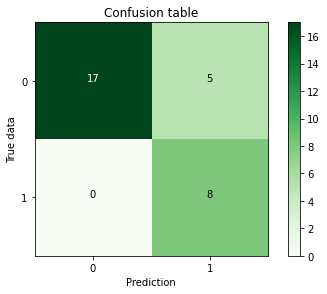

In [75]:
conf = confs[0] # select first class

classes = [0, 1]
# Visualization
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion table")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True data')
plt.xlabel('Prediction')

In [76]:
predicted

tensor([[0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

In [77]:
predictions # this is - predicted values y hat 

tensor([[0.2926, 0.2675, 0.4399],
        [0.1585, 0.4689, 0.3726],
        [0.3834, 0.3942, 0.2223],
        [0.4532, 0.3935, 0.1533],
        [0.4447, 0.4210, 0.1343],
        [0.2423, 0.4772, 0.2805],
        [0.2397, 0.2712, 0.4891],
        [0.1467, 0.3420, 0.5113],
        [0.4861, 0.2714, 0.2425],
        [0.2320, 0.4618, 0.3062],
        [0.0329, 0.1678, 0.7993],
        [0.4446, 0.3352, 0.2202],
        [0.5680, 0.3094, 0.1227],
        [0.6302, 0.2506, 0.1191],
        [0.2711, 0.3113, 0.4176],
        [0.2142, 0.3370, 0.4488],
        [0.3295, 0.4267, 0.2439],
        [0.5318, 0.2732, 0.1950],
        [0.3298, 0.2024, 0.4678],
        [0.3445, 0.2434, 0.4121],
        [0.3686, 0.2958, 0.3357],
        [0.3783, 0.3719, 0.2497],
        [0.4798, 0.3664, 0.1538],
        [0.1932, 0.5754, 0.2314],
        [0.2768, 0.4980, 0.2252],
        [0.4153, 0.4010, 0.1836],
        [0.4789, 0.2586, 0.2625],
        [0.4085, 0.3375, 0.2540],
        [0.3062, 0.3864, 0.3074],
        [0.236

In [78]:
# from the confusion matrix
TP = conf[1,1]
TN = conf[0,0]
FP = conf[0,1]
FN = conf[1,0]

### Some basic metrics

Now, we will calculate some basic metrics from these four values.  
We will need a dictionary to store these metrics. Lets create a dictionary `results`.

In [79]:
results = {}

#### Accuracy 
number of examples correctly predicted / total number of examples  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/c72ec21ef2505c2d376e96197637fc64f75e5891)

In [80]:
metric = "ACC"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {results[metric]: .3f}")

ACC is  0.833


#### True Positive Rate
number of samples actually and predicted as  `Positive` / total number of samples actually `Positive`  
Also called **Sensitivity or Recall**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/64d5540cbadeb83f864d7a731b7ab43cccd0f353)


In [81]:
# Sensitivity or Recall
metric = "TPR"
results[metric] = TP / (TP + FN)
print(f"{metric} is {results[metric]: .3f}")

TPR is  1.000


#### True Negative Rate
number of samples actually and predicted as  `Negative` / total number of samples actually  `Negative`  
Also called **Specificity**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/aac65b6586cb61c1268403895012c2a8f19b0c5e)


In [82]:
# Specificity
metric = "TNR"
results[metric] = TN / (TN + FP)
print(f"{metric} is {results[metric]: .3f}")

TNR is  0.773


#### Positive Predictive Value
number of samples actually and predicted as  `Positive` / total number of samples predicted as `Positive`  
Also called **Precision**.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/699fcdb880b7f6a92742bc0845b8b60b59806a98)


In [83]:
# Precision
metric = "PPV"
results[metric] = TP / (TP + FP)
print(f"{metric} is {results[metric]: .3f}")

PPV is  0.615


#### Negative Predictive Value
number of samples actually and predicted as  `Negative` / total number of samples predicted as `Negative`    
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/b6da0f59faffbc1704974e97847ab4fa599f5521)


In [84]:
metric = "NPV"
results[metric] = TN / (TN + FN)
print(f"{metric} is {results[metric]: .3f}")

NPV is  1.000


#### F1 score
Harmonic Mean of Precision and Recall.  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5663ca95d471868169c4e4ea57c936f1b6f4a588)

In [85]:
metric = "F1"
results[metric] = 2 / (1 / results["PPV"] + 1 / results["TPR"])
print(f"{metric} is {results[metric]: .3f}")

F1 is  0.762


#### Matthew's correlation coefficient
Matthew's coefficient range between `[-1, 1]`. `0` usually means totally random predictions. `1` means a perfect classifier, while a negative value (`[-1, 0)`) suggests a negative correlation between predictions and actual values.   
Here' the formual for MCC  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5caa90fc15105b74b59a30bbc9cc2e5bd43a13b7)

In [86]:
metric = "MCC"
num = TP * TN - FP * FN
den = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
results[metric] = num / den
print(f"{metric} is {results[metric]: .3f}")

MCC is  0.690


### Comparing these calculated metrics
Let's check if these values match with the values calculated from `scikit-learn`'s functions.

In [87]:
print(f"Calculated and Actual Accuracy:                          {results['ACC']: .3f}, {metrics.accuracy_score(y_test[:,0], predicted[:,0]): .3f}")
print(f"Calculated and Actual Precision score:                   {results['PPV']: .3f}, {metrics.precision_score(y_test[:,0], predicted[:,0]): .3f}")
print(f"Calculated and Actual Recall score:                      {results['TPR']: .3f}, {metrics.recall_score(y_test[:,0], predicted[:,0]): .3f}")
print(f"Calculated and Actual F1 score:                          {results['F1']: .3f}, {metrics.f1_score(y_test[:,0], predicted[:,0]): .3f}")
print(f"Calculated and Actual Matthew's correlation coefficient: {results['MCC']: .3f}, {metrics.matthews_corrcoef(y_test[:,0], predicted[:,0]): .3f}")

Calculated and Actual Accuracy:                           0.833,  0.833
Calculated and Actual Precision score:                    0.615,  0.615
Calculated and Actual Recall score:                       1.000,  1.000
Calculated and Actual F1 score:                           0.762,  0.762
Calculated and Actual Matthew's correlation coefficient:  0.690,  0.690


## Error analysis

In [88]:
predictions

tensor([[0.2926, 0.2675, 0.4399],
        [0.1585, 0.4689, 0.3726],
        [0.3834, 0.3942, 0.2223],
        [0.4532, 0.3935, 0.1533],
        [0.4447, 0.4210, 0.1343],
        [0.2423, 0.4772, 0.2805],
        [0.2397, 0.2712, 0.4891],
        [0.1467, 0.3420, 0.5113],
        [0.4861, 0.2714, 0.2425],
        [0.2320, 0.4618, 0.3062],
        [0.0329, 0.1678, 0.7993],
        [0.4446, 0.3352, 0.2202],
        [0.5680, 0.3094, 0.1227],
        [0.6302, 0.2506, 0.1191],
        [0.2711, 0.3113, 0.4176],
        [0.2142, 0.3370, 0.4488],
        [0.3295, 0.4267, 0.2439],
        [0.5318, 0.2732, 0.1950],
        [0.3298, 0.2024, 0.4678],
        [0.3445, 0.2434, 0.4121],
        [0.3686, 0.2958, 0.3357],
        [0.3783, 0.3719, 0.2497],
        [0.4798, 0.3664, 0.1538],
        [0.1932, 0.5754, 0.2314],
        [0.2768, 0.4980, 0.2252],
        [0.4153, 0.4010, 0.1836],
        [0.4789, 0.2586, 0.2625],
        [0.4085, 0.3375, 0.2540],
        [0.3062, 0.3864, 0.3074],
        [0.236

In [89]:
np.log(predictions.detach().numpy()).shape

(30, 3)

In [90]:
y_test.detach().numpy().shape

(30, 3)

In [91]:
error = -np.sum(y_test.detach().numpy()*np.log(predictions.detach().numpy()),axis=1)
error

array([1.3185662 , 0.75728267, 1.50352716, 0.79135084, 0.81034386,
       1.27109599, 0.71516609, 0.67089492, 0.72135419, 1.18361199,
       0.22399485, 1.09303415, 0.56570476, 0.46164751, 1.16684556,
       0.80125582, 0.85174346, 0.63155961, 1.59749591, 0.88652223,
       1.21815157, 0.9890151 , 0.7343812 , 1.46362686, 0.69719481,
       0.91372204, 0.736256  , 1.37034214, 1.17969048, 0.70147449])

In [92]:
err_idx = np.argsort(error)
err_idx

array([10, 13, 12, 17,  7, 24, 29,  6,  8, 22, 26,  1,  3, 15,  4, 16, 19,
       25, 21, 11, 14, 28,  9, 20,  5,  0, 27, 23,  2, 18])

In [93]:
y_test[err_idx], error[err_idx]

(tensor([[0, 0, 1],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 0, 1],
         [0, 1, 0],
         [0, 0, 1],
         [0, 0, 1],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [0, 1, 0],
         [1, 0, 0],
         [0, 0, 1],
         [1, 0, 0],
         [0, 1, 0],
         [0, 0, 1],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 1, 0],
         [0, 0, 1],
         [0, 0, 1],
         [0, 1, 0],
         [0, 0, 1],
         [0, 1, 0],
         [0, 0, 1],
         [0, 0, 1],
         [0, 0, 1],
         [0, 1, 0]]),
 array([0.22399485, 0.46164751, 0.56570476, 0.63155961, 0.67089492,
        0.69719481, 0.70147449, 0.71516609, 0.72135419, 0.7343812 ,
        0.736256  , 0.75728267, 0.79135084, 0.80125582, 0.81034386,
        0.85174346, 0.88652223, 0.91372204, 0.9890151 , 1.09303415,
        1.16684556, 1.17969048, 1.18361199, 1.21815157, 1.27109599,
        1.3185662 , 1.37034214, 1.46362686, 1.50352716, 1.